# Evaluation of GPU memory consumption for CUDA Tensors

In [1]:
import sys
sys.path.append("/Users/danielherbst/Desktop/evaluation")

In [2]:
from evaluation_routines.data_loading import OCPDataFrameLoader
from evaluation_routines.cuda_memory import CUDAMemory
from evaluation_routines.runtimes import Runtimes

## Data loading

At first, we specify the paths necessary for evaluation. This includes:
- the ocp metrics directory stored in `ocp_metrics_path`
- the directory `directory` for the specific model/series of runs we would like to consider
- the runs `runs` as a `dict` with shorter name as key and the respective csv filenames without "_resources/..." extensions

In [3]:
ocp_metrics_path = "/Users/danielherbst/Desktop/ocp-metrics"
directory = "s2ef/dimenetplusplus_xl/batch_size_2"

runs = {
    "S0":           "1659012218_stage0_8gpus",
    "S0+fp16":      "1659026432_stage0_8gpus",
    "S1":           "1659081619_stage1_8gpus",
    "S1+OC":        "1659044604_stage1_8gpus",
    "S2+OC":        "1659081620_stage2_8gpus",
    "S2+OO+OC":     "1659081621_stage2_8gpus",
    "S3+OC":        "1659059295_stage3_8gpus",
    "S3+PO+OO+OC":  "1659068622_stage3_8gpus_offloadOptimizer[cpu]_offloadParam[cpu]"
}
formatted_run_names_1 = [
    r"\textbf{S0}",
    r"\textbf{S0}" + "+fp16",
    r"\textbf{S1}",
    r"\textbf{S1}" + "+OC",
    r"\textbf{S2}" + "+OC",
    r"\textbf{S2}" + "+OO+OC",
    r"\textbf{S3}" + "+OC",
    r"\textbf{S3}" + "+PO+OO+OC"
]
formatted_run_names_2 = [
    r"\textbf{S0}",
    r"\textbf{S0}" + "+fp16",
    r"\textbf{S1}",
    r"\textbf{S1}" + "+OC",
    r"\textbf{S2}" + "+OC",
    r"\textbf{S2}" + "+OO\n+OC",
    r"\textbf{S3}" + "+OC",
    r"\textbf{S3}" + "+PO\n+OO+OC"
]
tick_colors = [
    "black",
    "black",
    "black",
    "black",
    "red",
    "red",
    "black",
    "black",
]

data_loader = OCPDataFrameLoader(ocp_metrics_path, directory, runs)
cuda_memory, runtimes = CUDAMemory(data_loader), Runtimes(data_loader)

In [4]:
resources_paths, torch_cuda_paths, runtimes_paths = data_loader.get_paths()

## Inspection of a single run

At first, we inspect single runs with a set DeepSpeed configuration. We look at statistical summaries of the allocated and reserved memory as well as runtimes.

In [5]:
cuda_df = data_loader.get_metrics_csv(torch_cuda_paths["S0"], csv_type="torch_cuda")
cuda_df

,datetime,epoch,rank,gpu_memory_allocated,gpu_memory_reserved
0,2022-07-28 12:43:40.539547,0,7,864.797184,891.289600
1,2022-07-28 12:43:40.539541,0,3,864.797184,891.289600
2,2022-07-28 12:43:40.539609,0,4,864.797184,891.289600
3,2022-07-28 12:43:40.539627,0,1,864.797184,891.289600
4,2022-07-28 12:43:40.539668,0,2,864.797184,891.289600
...,...,...,...,...,...
199995,2022-07-28 16:38:29.144254,0,5,3461.210624,35571.892224
199996,2022-07-28 16:38:29.144538,0,1,3459.441152,46074.429440
199997,2022-07-28 16:38:29.144554,0,6,3488.278528,33231.470592
199998,2022-07-28 16:38:29.144985,0,7,3461.513728,32247.906304


In [6]:
runtimes_df = data_loader.get_metrics_csv(runtimes_paths["S0"], csv_type="runtimes")
runtimes_df

,rank,epoch,epoch_time,dataloading_time,forward_time,backward_time,rest
0,7,0,14092.071324,20.233304,2504.550513,10574.917258,992.370250
1,6,0,14092.081328,25.443232,2407.960369,10597.217847,1061.459880
2,4,0,14092.083254,34.216081,2647.383901,10587.450639,823.032633
3,5,0,14092.087242,29.775443,2467.182092,10591.958102,1003.171605
4,1,0,14092.325961,26.103835,2278.226043,10589.281422,1198.714661
5,3,0,14092.344434,34.647751,2359.024093,10587.580763,1111.091826
6,2,0,14092.381621,29.902864,2371.277560,10565.018292,1126.182905
7,0,0,14094.136906,14.884475,2238.799556,10599.464740,1240.988135


In [7]:
runtimes.means("S0")

epoch_time          03:54:52
dataloading_time    00:00:26
forward_time        00:40:09
backward_time       02:56:26
rest                00:17:49
dtype: object

In [8]:
cuda_memory.summary_per_gpu("S0")

gpu_memory_allocated                                                   \
                    count         mean        std         min          25%   
rank                                                                         
0                 25000.0  3464.967040  16.445642  864.797184  3465.038336   
1                 25000.0  3459.322595  16.409948  864.797184  3459.390976   
2                 25000.0  3460.548656  16.417700  864.797184  3460.618752   
3                 25000.0  3460.471172  16.417219  864.797184  3460.537344   
4                 25000.0  3460.163031  16.415327  864.797184  3460.218880   
5                 25000.0  3461.080949  16.421086  864.797184  3461.146624   
6                 25000.0  3488.168774  16.592397  864.797184  3488.238080   
7                 25000.0  3461.398698  16.423093  864.797184  3461.464064   

                                            gpu_memory_reserved                \
              50%          75%          max               count          mean   
rank                                                                            
0     3465.070592  3465.103360  3465.276928             25000.0  31246.247369   
1     3459.425792  3459.460096  3459.624448             25000.0  37091.091866   
2     3460.651008  3460.685312  3460.825088             25000.0  39744.701339   
3     3460.576768  3460.610048  3460.790784             25000.0  39874.391483   
4     3460.261888  3460.308480  3460.493824             25000.0  36285.963924   
5     3461.182464  3461.220352  3461.424640             25000.0  34235.806164   
6     3488.273408  3488.309248  3488.483840             25000.0  35578.450186   
7     3461.502464  3461.539328  3461.711872             25000.0  32527.112229   

                                                                       \
              std       min           25%           50%           75%   
rank                                                                    
0     3951.523388  891.2896  28265.414656  30949.769216  35420.897280   
1     7997.460161  891.2896  29695.672320  36641.439744  46074.429440   
2     8231.159654  891.2896  29546.774528  46036.680704  46036.680704   
3     9001.173129  891.2896  31266.439168  44879.052800  48731.521024   
4     1004.809224  891.2896  35724.984320  36769.366016  36769.366016   
5     2012.266493  891.2896  33254.539264  34728.837120  35947.282432   
6     4632.829993  891.2896  33231.470592  33231.470592  33231.470592   
7     2554.379534  891.2896  32237.420544  32237.420544  32237.420544   

                    
               max  
rank                
0     37931.188224  
1     46074.429440  
2     48771.366912  
3     48731.521024  
4     36769.366016  
5     44061.163520  
6     44405.096448  
7     46972.010496

In [9]:
cuda_memory.summary_averaged("S0")

,gpu_memory_allocated,gpu_memory_reserved
count,200000.000000,200000.000000
mean,3464.515114,35822.970570
std,18.781887,6416.672302
min,864.797184,891.289600
25%,3460.465536,31266.439168
50%,3460.819200,33254.539264
75%,3461.698176,36769.366016
max,3488.483840,48771.366912


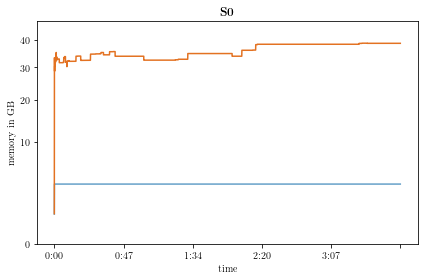

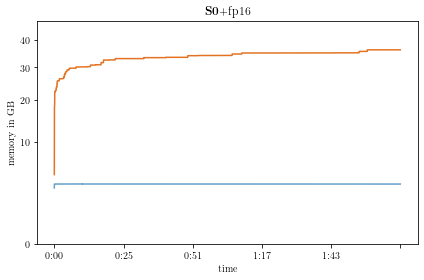

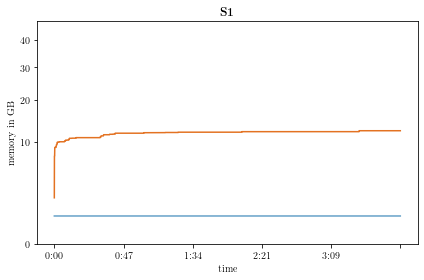

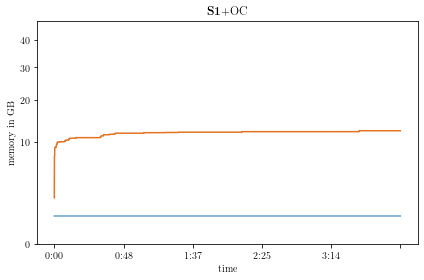

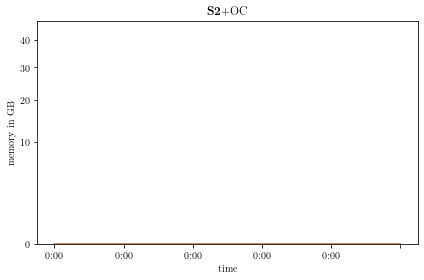

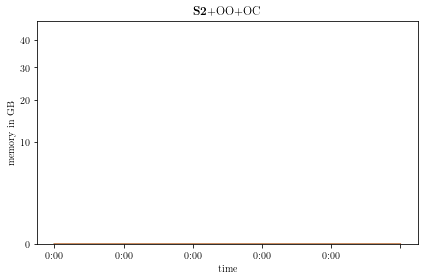

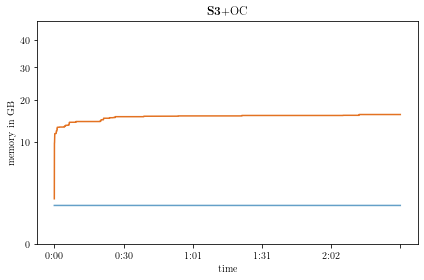

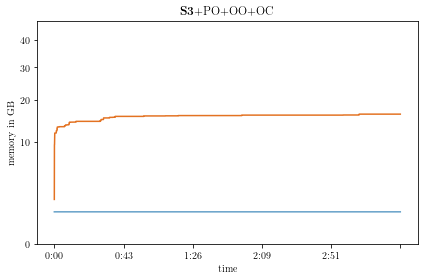

In [10]:
for i, run in enumerate(runs):
    cuda_memory.plot_cuda_memory(
        run, 
        mode="averaged", 
        title=formatted_run_names_1[i],
        save=True, 
        save_dir="../outputs/dimenet/s2ef/cuda_memory"
    )

For a single run, the GPU CUDA torch memory consumption can be plotted versus time, individually on each GPU or averaged/summed across all involved GPUs.

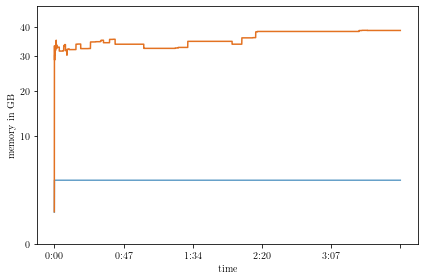

In [11]:
cuda_memory.plot_cuda_memory("S0", mode="averaged")

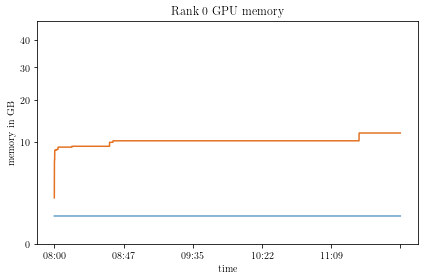

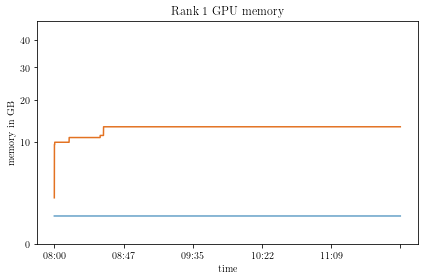

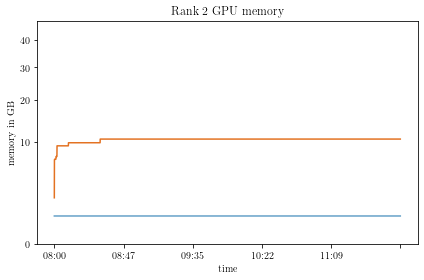

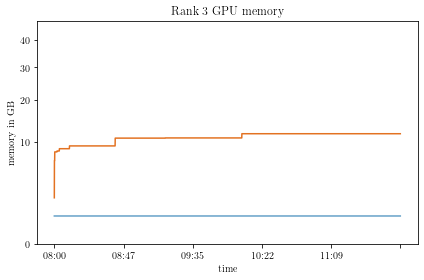

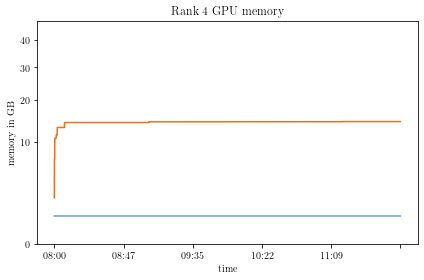

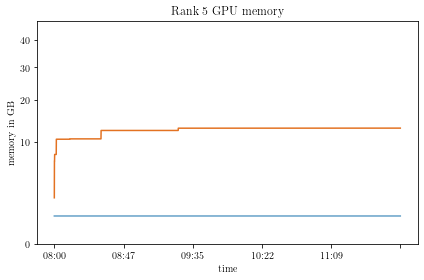

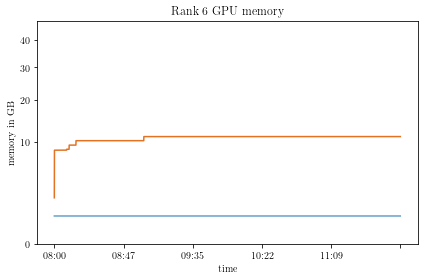

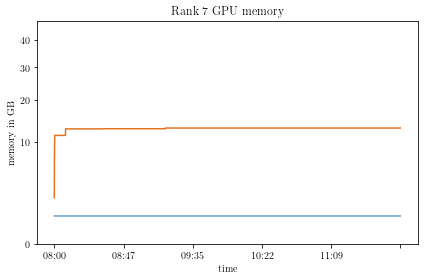

In [12]:
cuda_memory.plot_cuda_memory("S1", mode="individual")

## Comparison of memory and runtimes for different runs

For different runs, the allocated and reserved GPU CUDA memory as well as the runtimes can be compared.

In [13]:
runtimes.compare(save=True, save_dir="../outputs/dimenet/s2ef/runtimes")

,S0,S0+fp16,S1,S1+OC,S2+OC,S2+OO+OC,S3+OC,S3+PO+OO+OC
epoch_time,03:54:52,02:09:22,03:56:28,04:02:47,00:00:00,00:00:00,02:33:25,03:34:34
dataloading_time,00:00:26,00:00:28,00:01:39,00:01:44,00:00:00,00:00:00,00:00:17,00:00:19
forward_time,00:40:09,00:24:52,00:19:14,00:19:41,00:00:00,00:00:00,00:43:02,00:43:50
backward_time,02:56:26,01:36:06,01:23:00,01:24:09,00:00:00,00:00:00,01:45:56,02:46:15
rest,00:17:49,00:07:54,02:12:33,02:17:11,00:00:00,00:00:00,00:04:08,00:04:10


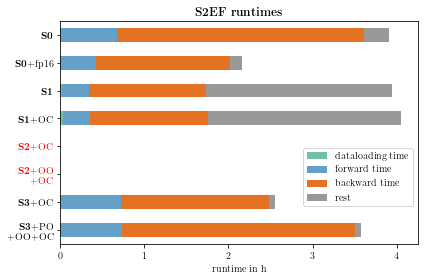

In [14]:
runtimes.compare_plot(
    yticks=formatted_run_names_2, 
    tick_colors=tick_colors,
    figsize=(6, 4), 
    title=r"\textbf{S2EF runtimes}", 
    save=True, 
    save_dir="../outputs/dimenet/s2ef/runtimes"
)

In [15]:
cuda_memory.compare(save=True, save_dir="../outputs/dimenet/s2ef/cuda_memory")

,S0,S0+fp16,S1,S1+OC,S2+OC,S2+OO+OC,S3+OC,S3+PO+OO+OC
gpu_memory_allocated,3.46,3.47,0.76,0.76,0.0,0.0,1.44,1.00
gpu_memory_reserved,35.82,33.83,11.87,11.87,0.0,0.0,15.59,15.67


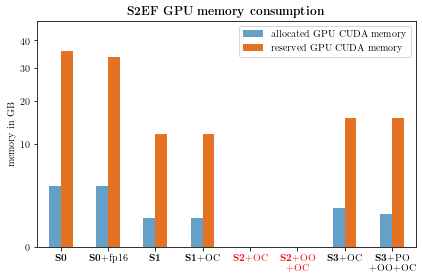

In [16]:
cuda_memory.compare_plot(
    xticks=formatted_run_names_2, 
    tick_colors=tick_colors,
    figsize=(6, 4), 
    title=r"\textbf{S2EF GPU memory consumption}", 
    save=True, 
    save_dir="../outputs/dimenet/s2ef/cuda_memory"
)